# IHLT Lab 3: Morphology

**Authors:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu)), Carlos Jiménez ([carlos.humberto.jimenez](mailto:carlos.humberto.jimenez@estudiantat.upc.edu))*

### 2024-10-03

**Instructions:**

1. Read all pairs of sentences of the *SMTeuroparl* files of test set within the evaluation framework of the project.
2. Compute their similarities by considering lemmas and Jaccard distance.
3. Compare the results with those in session 2 (*document structure*) in which words were considered.
4. Compare the results with gold standard by giving the pearson correlation between them.
5. Questions (justify the answers):

    - Which is better: words or lemmas?
    - Do you think that could perform better for any pair of texts?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import nltk
from nltk.metrics.distance import jaccard_distance

In [2]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read data from Google Drive

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# BASE_PATH = '/content/drive/MyDrive/MASTER AI'

In [4]:
# Read data from local file system

BASE_PATH = '.'

In [5]:
assert BASE_PATH is not None, "BASE_PATH is not set"

## Load the data

In [6]:
dt = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.input.SMTeuroparl.txt", sep="\t", header=None
)
dt.columns = ["s1", "s2"]
gs = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.gs.SMTeuroparl.txt", sep="\t", header=None
)
dt["gs"] = gs[0]
dt.head()

,s1,s2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Lemmatizer & Helper methods

In [7]:
# Lemmatization methods
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize_one(word):
    x, pos = nltk.pos_tag([word])[0]
    d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
    if pos in d:
        return wnl.lemmatize(word, pos=d[pos])
    return x

def lemmatize_many(words):
    return [lemmatize_one(word) for word in words]

In [8]:
# Token pre-processing methods
def remove_non_alnum(tokens):
    return [token for token in tokens if token.isalnum()]

def lower(tokens):
    return [token.lower() for token in tokens]

def remove_stopwords(tokens):
    return [token for token in tokens if token not in nltk.corpus.stopwords.words("english")]

In [9]:
# Scoring methods
def jaccard_vector(s1, s2):
    return pd.concat([s1, s2], axis=1).apply(lambda x: jaccard_distance(set(x.iloc[0]), set(x.iloc[1])), axis=1)

def score_jaccard_vector(jaccard_vector):
    return pearsonr(gs[0], jaccard_vector)[0]

## Compute jaccard distance for different preprocessing approaches and compare

In [10]:
results = pd.DataFrame(index=['score'])

# Tokenize
s1_tokens = dt['s1'].apply(nltk.word_tokenize)
s2_tokens = dt['s2'].apply(nltk.word_tokenize)
results['tokenize'] = score_jaccard_vector(jaccard_vector(s1_tokens, s2_tokens))

dt["jaccard"] = jaccard_vector(s1_tokens, s2_tokens)

# Lower
s1_lower = s1_tokens.apply(lower)
s2_lower = s2_tokens.apply(lower)
results['lower'] = score_jaccard_vector(jaccard_vector(s1_lower, s2_lower))

# Remove non-alphanumeric
s1_alnum = s1_lower.apply(remove_non_alnum)
s2_alnum = s2_lower.apply(remove_non_alnum)
results['remove_non_alnum'] = score_jaccard_vector(jaccard_vector(s1_alnum, s2_alnum))

# Lemmatize
s1_lemmas = s1_alnum.apply(lemmatize_many)
s2_lemmas = s2_alnum.apply(lemmatize_many)
results['lemmatize'] = score_jaccard_vector(jaccard_vector(s1_lemmas, s2_lemmas))

dt["jaccard_lemmatized"] = jaccard_vector(s1_lemmas, s2_lemmas)
dt["gs"] = gs[0]

print("\033[1mJaccard Distance Correlation with Gold Standard after Each Preprocessing Step:\033[0m")
print()
print(results)


Jaccard Distance Correlation with Gold Standard after Each Preprocessing Step:

       tokenize     lower  remove_non_alnum  lemmatize
score -0.450498 -0.462495         -0.490289  -0.495849


## Compute jaccard distance removing stopwords (lab2 camparison criterion)

In [11]:
results_no_stopwords = pd.DataFrame(index=['score'])

# Tokenize
s1_tokens = dt['s1'].apply(nltk.word_tokenize)
s2_tokens = dt['s2'].apply(nltk.word_tokenize)
results_no_stopwords['tokenize'] = score_jaccard_vector(jaccard_vector(s1_tokens, s2_tokens))

# Lower
s1_lower = s1_tokens.apply(lower)
s2_lower = s2_tokens.apply(lower)
results_no_stopwords['lower'] = score_jaccard_vector(jaccard_vector(s1_lower, s2_lower))

# Remove non-alphanumeric
s1_alnum = s1_lower.apply(remove_non_alnum)
s2_alnum = s2_lower.apply(remove_non_alnum)
results_no_stopwords['remove_non_alnum'] = score_jaccard_vector(jaccard_vector(s1_alnum, s2_alnum))

# Remove stopwords
s1_no_stopwords = s1_alnum.apply(remove_stopwords)
s2_no_stopwords = s2_alnum.apply(remove_stopwords)
results_no_stopwords['remove_stopwords'] = score_jaccard_vector(jaccard_vector(s1_no_stopwords, s2_no_stopwords))

dt["jaccard_no_stopwords"] = jaccard_vector(s1_no_stopwords, s2_no_stopwords)

# Lemmatize
s1_lemmas = s1_no_stopwords.apply(lemmatize_many)
s2_lemmas = s2_no_stopwords.apply(lemmatize_many)
results_no_stopwords['lemmatize'] = score_jaccard_vector(jaccard_vector(s1_lemmas, s2_lemmas))

dt["jaccard_lemmatized_no_stopwords"] = jaccard_vector(s1_lemmas, s2_lemmas)
# dt["gs"] = gs[0]

print("\033[1mJaccard Distance Correlation with Gold Standard removing stop words:\033[0m")
print()
print(results_no_stopwords)

Jaccard Distance Correlation with Gold Standard removing stop words:

       tokenize     lower  remove_non_alnum  remove_stopwords  lemmatize
score -0.450498 -0.462495         -0.490289         -0.480942  -0.503693


In [12]:
leave_one_out_results = pd.DataFrame(index=['score'])

# Base tokenization (always included)
s1_tokens = dt['s1'].apply(nltk.word_tokenize)
s2_tokens = dt['s2'].apply(nltk.word_tokenize)

# Configuration 1: Skip lowercase
s1_config1 = s1_tokens.apply(remove_non_alnum).apply(remove_stopwords).apply(lemmatize_many)
s2_config1 = s2_tokens.apply(remove_non_alnum).apply(remove_stopwords).apply(lemmatize_many)
leave_one_out_results['skip_lowercase'] = score_jaccard_vector(jaccard_vector(s1_config1, s2_config1))

# Configuration 2: Skip remove non-alnum
s1_config2 = s1_tokens.apply(lower).apply(remove_stopwords).apply(lemmatize_many)
s2_config2 = s2_tokens.apply(lower).apply(remove_stopwords).apply(lemmatize_many)
leave_one_out_results['skip_remove_non_alnum'] = score_jaccard_vector(jaccard_vector(s1_config2, s2_config2))

# Configuration 3: Skip remove stopwords
s1_config3 = s1_tokens.apply(lower).apply(remove_non_alnum).apply(lemmatize_many)
s2_config3 = s2_tokens.apply(lower).apply(remove_non_alnum).apply(lemmatize_many)
leave_one_out_results['skip_remove_stopwords'] = score_jaccard_vector(jaccard_vector(s1_config3, s2_config3))

# Configuration 4: Skip lemmatize
s1_config4 = s1_tokens.apply(lower).apply(remove_non_alnum).apply(remove_stopwords)
s2_config4 = s2_tokens.apply(lower).apply(remove_non_alnum).apply(remove_stopwords)
leave_one_out_results['skip_lemmatize'] = score_jaccard_vector(jaccard_vector(s1_config4, s2_config4))

# Add the full pipeline for comparison
s1_full = s1_tokens.apply(lower).apply(remove_non_alnum).apply(remove_stopwords).apply(lemmatize_many)
s2_full = s2_tokens.apply(lower).apply(remove_non_alnum).apply(remove_stopwords).apply(lemmatize_many)
leave_one_out_results['full_pipeline'] = score_jaccard_vector(jaccard_vector(s1_full, s2_full))

print("\033[1mJaccard Distance Correlation with Gold Standard for different configurations:\033[0m")
print()
print(leave_one_out_results)

Jaccard Distance Correlation with Gold Standard for different configurations:

       skip_lowercase  skip_remove_non_alnum  skip_remove_stopwords  \
score       -0.471052              -0.465986              -0.495849   

       skip_lemmatize  full_pipeline  
score       -0.480942      -0.503693  


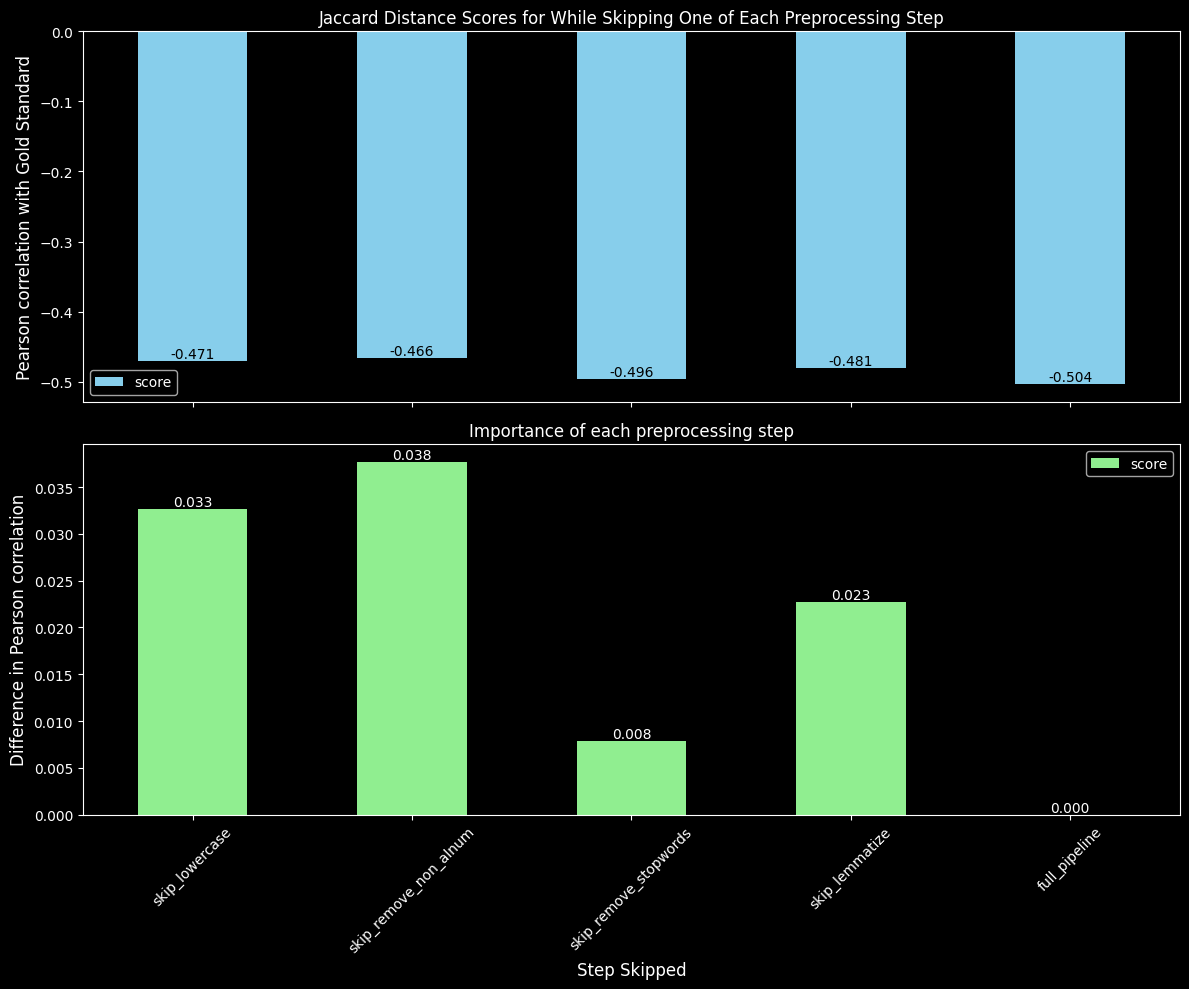

In [13]:
# Plot bar chart for leave-one-out results and differences from full pipeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Original bar chart
leave_one_out_results.T.plot(kind='bar', color=['skyblue'], ax=ax1)
ax1.set_title('Jaccard Distance Scores for While Skipping One of Each Preprocessing Step')
ax1.set_ylabel('Pearson correlation with Gold Standard', fontsize=12)


# Annotate original bar chart values
for i, v in enumerate(leave_one_out_results.values[0]):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom', color='black')

# Calculate and plot differences from full pipeline
full_pipeline_score = leave_one_out_results['full_pipeline'].values[0]
differences = leave_one_out_results.subtract(full_pipeline_score).T
differences.plot(kind='bar', color=['lightgreen'], ax=ax2)
ax2.set_title('Importance of each preprocessing step')
ax2.set_xlabel('Step Skipped', fontsize=12)
ax2.set_ylabel('Difference in Pearson correlation', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Annotate difference bar chart values
for i, v in enumerate(differences.values):
    ax2.text(i, v, f'{v[0]:.3f}', ha='center', va='bottom' if v[0] >= 0 else 'top')

plt.tight_layout()
plt.show()


## Visualizations of the jaccard distance correlation scores for each preprocessing step

<Figure size 1000x600 with 0 Axes>

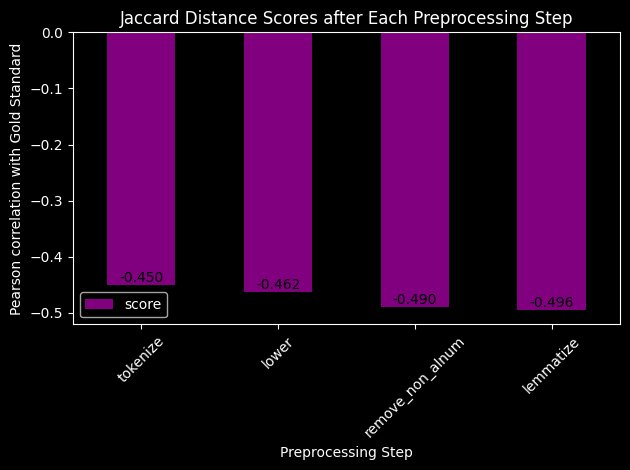

In [14]:
# Plot bar chart
plt.figure(figsize=(10, 6))
results.T.plot(kind='bar', color=['purple'])
plt.title('Jaccard Distance Scores after Each Preprocessing Step')
plt.xlabel('Preprocessing Step')
plt.ylabel('Pearson correlation with Gold Standard')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate bar chart values
for i, v in enumerate(results.values[0]):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom', color='black')
plt.show()

<Figure size 1000x600 with 0 Axes>

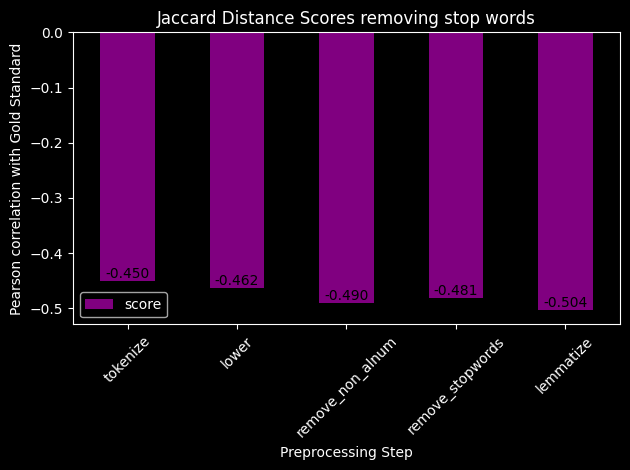

In [15]:
# Plot bar chart
plt.figure(figsize=(10, 6))
results_no_stopwords.T.plot(kind='bar', color=['purple'])
plt.title('Jaccard Distance Scores removing stop words')
plt.xlabel('Preprocessing Step')
plt.ylabel('Pearson correlation with Gold Standard')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate bar chart values
for i, v in enumerate(results_no_stopwords.values[0]):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom', color='black')
plt.show()

## Visualizations of the correlation between scores (jaccard vs GS) using lemmatization

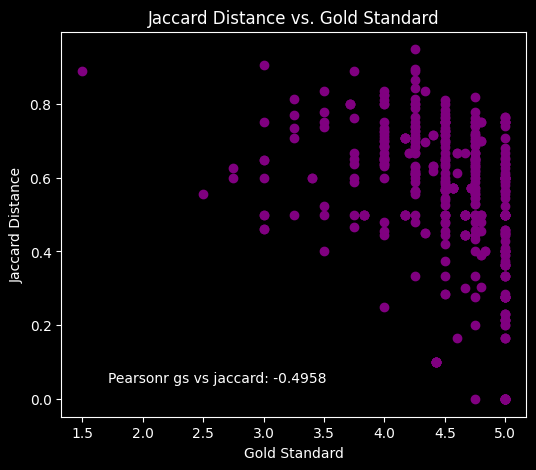

In [16]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes()

plt.scatter(dt["gs"], dt["jaccard"], color='purple')
plt.xlabel("Gold Standard")
plt.ylabel("Jaccard Distance")
plt.title("Jaccard Distance vs. Gold Standard")
plt.text(
    0.1,
    0.1,
    f"Pearsonr gs vs jaccard: {results['lemmatize'].iloc[0]:.4f}",
    transform=ax.transAxes,
    ha="left",
    va="center",
)
plt.show()

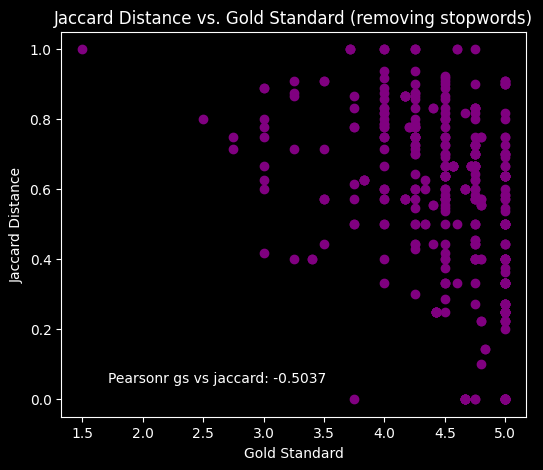

In [17]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes()

plt.scatter(dt["gs"], dt["jaccard_no_stopwords"], color='purple')
plt.xlabel("Gold Standard")
plt.ylabel("Jaccard Distance")
plt.title("Jaccard Distance vs. Gold Standard (removing stopwords)")
plt.text(
    0.1,
    0.1,
    f"Pearsonr gs vs jaccard: {results_no_stopwords['lemmatize'].iloc[0]:.4f}",
    transform=ax.transAxes,
    ha="left",
    va="center",
)
plt.show()

# Conclusions

## Which is better: words or lemmas?

#### In this lab we dived into a new approach for computing simmilarities/distance between sentences using ***lemmatization***.

#### We performed a series of preprocessing steps in order to compare the similaries. The results showed that using lemmatization (in average) improved the jaccard distance correlation between the sentences, not only that, we discovered that each of the selected preprocessing steps (*i.e.*, lowercase, remove non alphanumeric values) also helped to improve the scores as shown in the following table.

|  | tokenize | lower | remove_non_alnum | lemmatize |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| **regular** | -0.450498 | -0.462495 | -0.490289 | -0.495849 |
| **removing stopwords** | -0.424682 | -0.432894 | -0.465416 | -0.489301 |

#### Notably, the present work supports the findings from Lab 2 regarding the removal of stopwords, showing that this step does not improve the Jaccard distance correlation of the sentences, even when lemmatization is used.

## Do you think that lemmas could perform better for any pair of texts?

#### - We cannot assume that lemmas will always perform better for every single text, we have to take into consideration several aspects, including the language, length of the text, format, etc.

#### - For instance, within our lab corpus (*SMTeuroparl*), we can point out some examples in our dataframe, as follows:


In [18]:
dt.head()

,s1,s2,gs,jaccard,jaccard_lemmatized,jaccard_no_stopwords,jaccard_lemmatized_no_stopwords
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50,0.653846,0.652174,0.692308,0.692308
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00,0.214286,0.230769,0.250000,0.250000
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25,0.608696,0.619048,0.727273,0.727273
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50,0.454545,0.142857,0.250000,0.250000
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00,0.000000,0.000000,0.000000,0.000000


In [19]:
list(dt.iloc[0,:][['s1','s2']])

['The leaders have now been given a new chance and let us hope they seize it.',
 "The leaders benefit aujourd' hui of a new luck and let's let them therefore seize it."]

In [20]:
list(dt.iloc[3,:][['s1','s2']])

['The vote will take place today at 5.30 p.m.',
 'The vote will take place at 5.30pm']

#### Rows 0 and 3 are examples of regular tokenization performing better than lemmatization for computing similarities. In these cases the cause may be mixing languages (*i.e.*, english and french) or using different formats (*i.e.*, 5.30p.m. & 5.30pm)